# Sequence-to-Sequence Model with Frame-Level Discritisation

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import batching
import plotting
import samediff
import tflego
import training

output_dir = "/tmp/data-kamperh/"

## Data

In [5]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1_utd_terms.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_speakers = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    speaker = utt_key.split("_")[1][:3]
    train_labels.append(word)
    train_speakers.append(speaker)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12021
E.g. item shape: (62, 39)


In [6]:
# Convert training speakers to integers
train_speaker_set = set(train_speakers)
speaker_to_id = {}
id_to_speaker = {}
for i, speaker in enumerate(sorted(list(train_speaker_set))):
    speaker_to_id[speaker] = i
    id_to_speaker[i] = speaker
train_speaker_id = []
for speaker in train_speakers:
    train_speaker_id.append(speaker_to_id[speaker])
train_speaker_id = np.array(train_speaker_id, dtype=NP_ITYPE)

speaker_gender_dict = {
    "s01": "f", "s02": "f", "s03": "m", "s04": "f", "s05": "f", "s06": "m",
    "s07": "f", "s08": "f", "s09": "f", "s10": "m", "s11": "m", "s12": "f",
    "s13": "m", "s14": "f", "s15": "m", "s16": "f", "s17": "f", "s18": "f",
    "s19": "m", "s20": "f", "s21": "f", "s22": "m", "s23": "m", "s24": "m",
    "s25": "f", "s26": "f", "s27": "f", "s28": "m", "s29": "m", "s30": "m",
    "s31": "f", "s32": "m", "s33": "m", "s34": "m", "s35": "m", "s36": "m",
    "s37": "f", "s38": "m", "s39": "f", "s40": "m"
    }

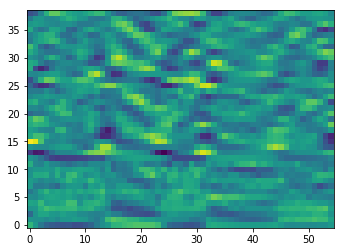

In [7]:
plt.imshow(train_x[3277].T, origin="bottom");

In [8]:
# Validation data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [9]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

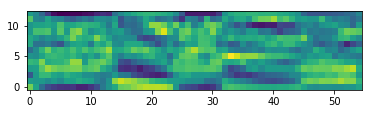

In [10]:
plt.imshow(train_x[3277].T, origin="bottom");

## Many-to-many sequence-to-sequence model with frame-level autoencoder

In [18]:
from tflego import *

def build_multi_many_to_many_latentfunc(x, x_lengths, enc_n_hiddens,
        dec_n_hiddens, build_latent_func, latent_func_kwargs, rnn_type="lstm",
        keep_prob=1., add_conditioning_tensor=None, **kwargs):
    """
    Multi-layer many-to-many model with a per-frame latent layer.

    A linear transformation is applied to the output of the decoder such that
    the final output dimensionality matches that of the input `x`. A generic
    latent layer is built according to the `build_latent_func` and
    `latent_func_kwargs` parameters.

    Parameters
    ----------
    x : Tensor [n_data, maxlength, d_in]
    build_latent_func : function
        The function to build the latent layer. The function's first parameter
        should be the input Tensor, and it should return a dictionary with an
        element "y" giving the output.
    latent_func_kargs : dict
        Arguments to pass on to `build_latent_func`.
    add_conditioning_tensor : Tensor [n_data, d_embedding]
        If provided, each time step of the decoder is conditioned on the 
        concatenation of the latent representation and this tensor.
    """

    maxlength = tf.reduce_max(x_lengths)
    n_output = x.get_shape().as_list()[-1]

    # Encoder
    encoder_output, encoder_states = build_multi_rnn(
        x, x_lengths, enc_n_hiddens, rnn_type, keep_prob,
        scope="rnn_encoder", **kwargs
        )

    # Latent transformation
    encoder_output_flattened = tf.reshape(
        encoder_output, [-1, enc_n_hiddens[-1]]
        )
    latent_layer = build_latent_func(
        encoder_output_flattened, **latent_func_kwargs
        )
    latent_layer_output = tf.reshape(latent_layer["y"], [-1, maxlength, dec_n_hiddens[0]])
    
    assert add_conditioning_tensor is None  # to-do (will have to use tile then concat)

    # Decoder
    decoder_output, decoder_states = build_multi_rnn(
        latent_layer_output, x_lengths, dec_n_hiddens, rnn_type, keep_prob,
        scope="rnn_decoder", **kwargs
        )
    mask = tf.sign(tf.reduce_max(tf.abs(decoder_output), 2))

    # Final linear layer
    with tf.variable_scope("rnn_decoder/linear_output"):
        decoder_output = tf.reshape(decoder_output, [-1, dec_n_hiddens[-1]])
        decoder_output = build_linear(decoder_output, n_output)
        decoder_output = tf.reshape(decoder_output, [-1, maxlength, n_output])
        decoder_output *= tf.expand_dims(mask, -1)

    return {
        "encoder_output": encoder_output, "latent_layer": latent_layer, 
        "decoder_output": decoder_output, "mask": mask, "maxlength": maxlength
        }

In [35]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
n_speakers = max(speaker_to_id.values()) + 1
# d_speaker_embedding = 50
enc_n_hiddens = [10]
dec_n_hiddens = [10]
# dec_n_hiddens = [400 + d_speaker_embedding, 400, 400]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [dec_n_hiddens[0]],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_ae.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_ae.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
# speaker_id = tf.placeholder(TF_ITYPE, [None])

# with tf.variable_scope("speaker_embedding"):
#     speaker_embedding = tf.get_variable(
#             "E", [n_speakers, d_speaker_embedding], dtype=TF_DTYPE,
#             initializer=tf.contrib.layers.xavier_initializer()
#             )
#     embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id)

network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
#     add_conditioning_tensor=embedding_lookup
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
ae = network_dict["latent_layer"]
z = tf.reshape(ae["z"], [-1, maxlength, latent_func_kwargs["n_z"]])
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - decoder_output), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [36]:
np.random.seed(1)
train_batch_iterator = batching.SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = batching.SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x, x_lengths], loss, val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-10 15:37:26.900342
Epoch 0:
5.591 sec, train loss: 1.3679999, val loss: 1.2095138 *
Epoch 1:
5.077 sec, train loss: 1.0229568, val loss: 1.0016029 *
Epoch 2:
5.122 sec, train loss: 0.8657509, val loss: 0.88121444 *
Epoch 3:
5.428 sec, train loss: 0.7759287, val loss: 0.8078553 *
Epoch 4:
5.108 sec, train loss: 0.7174857, val loss: 0.75648534 *
Epoch 5:
5.101 sec, train loss: 0.676386, val loss: 0.7188575 *
Epoch 6:
5.081 sec, train loss: 0.6447702, val loss: 0.6885063 *
Epoch 7:
5.099 sec, train loss: 0.61820847, val loss: 0.6620794 *
Epoch 8:
5.110 sec, train loss: 0.5940751, val loss: 0.6374878 *
Epoch 9:
5.279 sec, train loss: 0.56833744, val loss: 0.60729563 *
Epoch 10:
5.401 sec, train loss: 0.536568, val loss: 0.5729854 *
Epoch 11:
5.133 sec, train loss: 0.5102635, val loss: 0.54967815 *
Epoch 12:
5.102 sec, train loss: 0.49029416, val loss: 0.53061473 *
Epoch 13:
5.125 sec, train loss: 0.47363815, val loss: 0.51448655 *
Epoch 14:
5.085 sec, train loss: 0.4591958, val los

In [39]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_ae.ckpt


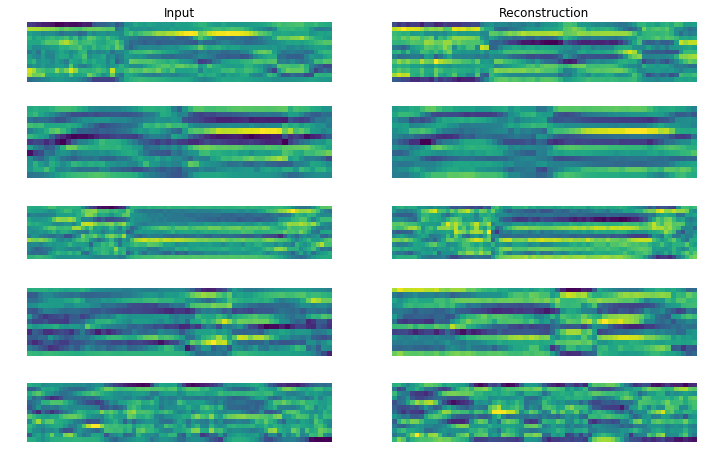

In [40]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")